In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [206]:
# 设置中文字体（Windows系统通常使用'SimHei'，Mac/Linux使用'Heiti TC'或'WenQuanYi Zen Hei'）
plt.rcParams['font.sans-serif'] = ['SimHei']  # 替换为系统已有的中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

In [207]:
df = pd.read_csv('weather_data_3hourly_sample2024.csv')
print(df.head())

             Date_Time      Location  Temperature_C  Humidity_pct  \
0  2024-01-01 00:00:00       Phoenix       0.618582     46.871717   
1  2024-01-01 03:00:00       Phoenix      -3.420331     83.540750   
2  2024-01-01 06:00:00  Philadelphia      16.658009     32.586440   
3  2024-01-01 09:00:00  Philadelphia      37.808727     74.923934   
4  2024-01-01 12:00:00     San Diego      -9.114067     70.314606   

   Precipitation_mm  Wind_Speed_kmh  
0          7.379615        5.321995  
1          4.411071        1.872854  
2          2.613779        7.117304  
3          6.763522       27.864432  
4          9.856279        9.885524  


In [208]:
# 转换时间列格式
df['Date_Time'] = pd.to_datetime(df['Date_Time'])
df['Month'] = df['Date_Time'].dt.month
df['Day'] = df['Date_Time'].dt.day

In [209]:
def calculate_thi(T, RH):
    """温度湿度指数公式"""
    thi = (1.8 * T + 32) - (0.55 - 0.55 * (RH / 100)) * (1.8 * T - 26)
    return round(thi, 2)

df['THI'] = df.apply(lambda row: calculate_thi(row['Temperature_C'], row['Humidity_pct']), axis=1)

In [210]:
def classify_comfort(thi):
    if thi < 15: return "寒冷"
    elif 15 <= thi < 20: return "凉冷"
    elif 20 <= thi < 26: return "舒适"
    elif 26 <= thi <= 30: return "轻度不适"
    else: return "重度不适"

df['Comfort_Level'] = df['THI'].apply(classify_comfort)

In [211]:
# 4.1 各城市THI统计
city_stats = df.groupby('Location')['THI'].agg(['mean', 'max', 'min', 'std']).rename(
    columns={'mean': 'THI_Mean', 'max': 'THI_Max', 'min': 'THI_Min', 'std': 'THI_Std'}
)

In [212]:
# 4.2 各城市舒适天数占比
comfort_days = df.groupby(['Location', 'Month'])['Comfort_Level'].apply(
    lambda x: (x == '舒适').mean() * 100
).unstack().round(1)

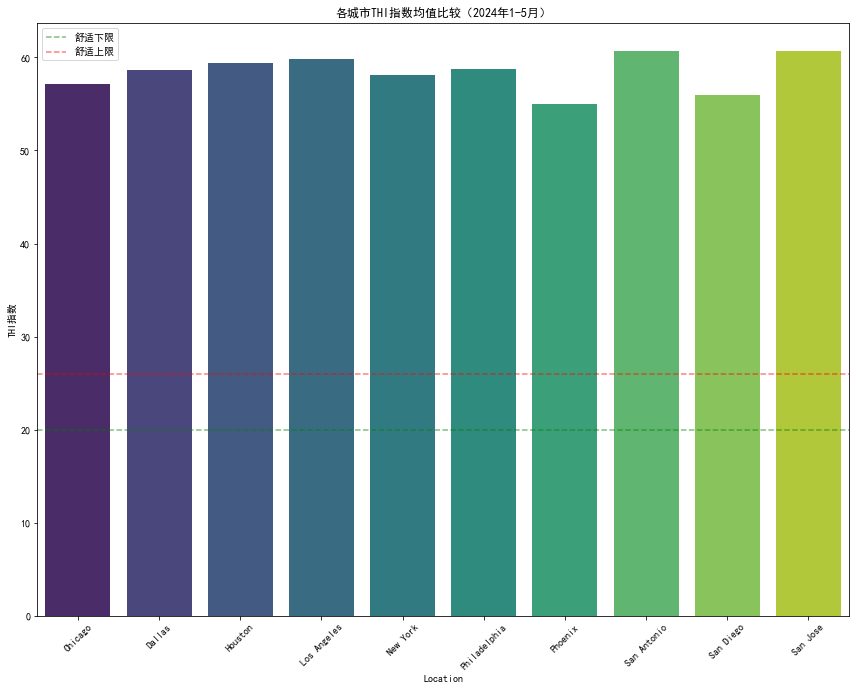

In [213]:
# 5.1 各城市THI均值比较
plt.figure(figsize=(32, 24)) 
plt.subplot(2, 2, 1)
sns.barplot(x=city_stats.index, y='THI_Mean', data=city_stats, palette='viridis')
plt.axhline(y=20, color='green', linestyle='--', alpha=0.5, label='舒适下限')
plt.axhline(y=26, color='red', linestyle='--', alpha=0.5, label='舒适上限')
plt.title('各城市THI指数均值比较（2024年1-5月）')
plt.xticks(rotation=45)
plt.ylabel('THI指数')
plt.legend()

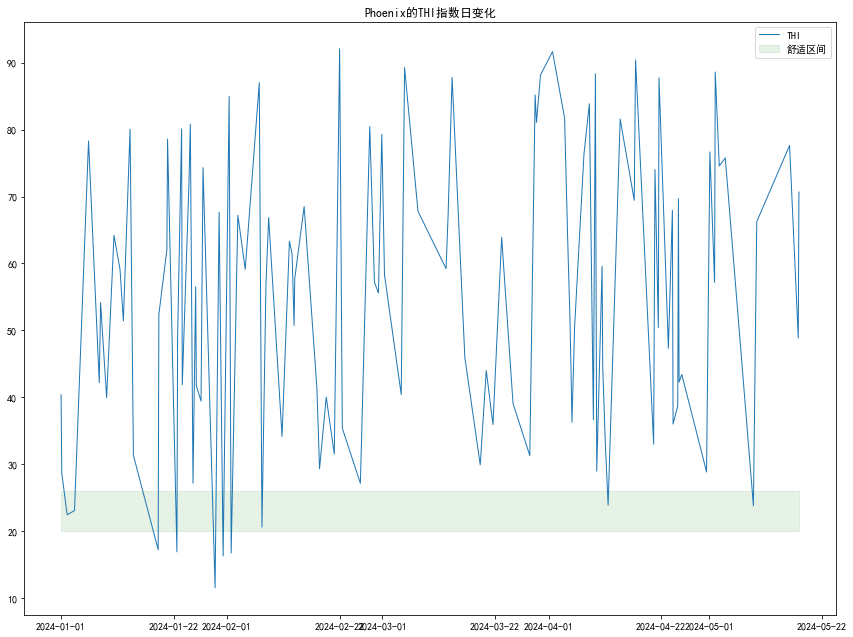

In [214]:
# 5.2 示例城市（第一个城市）的THI日变化
sample_city = df['Location'].iloc[0]
plt.figure(figsize=(32, 24)) 
plt.subplot(2, 2, 2)
city_data = df[df['Location'] == sample_city]
plt.plot(city_data['Date_Time'], city_data['THI'], label='THI', linewidth=1)
plt.fill_between(city_data['Date_Time'], 20, 26, color='green', alpha=0.1, label='舒适区间')
plt.title(f'{sample_city}的THI指数日变化')
plt.legend()

Text(0.5, 1.0, '各城市月度舒适天数占比(%)')

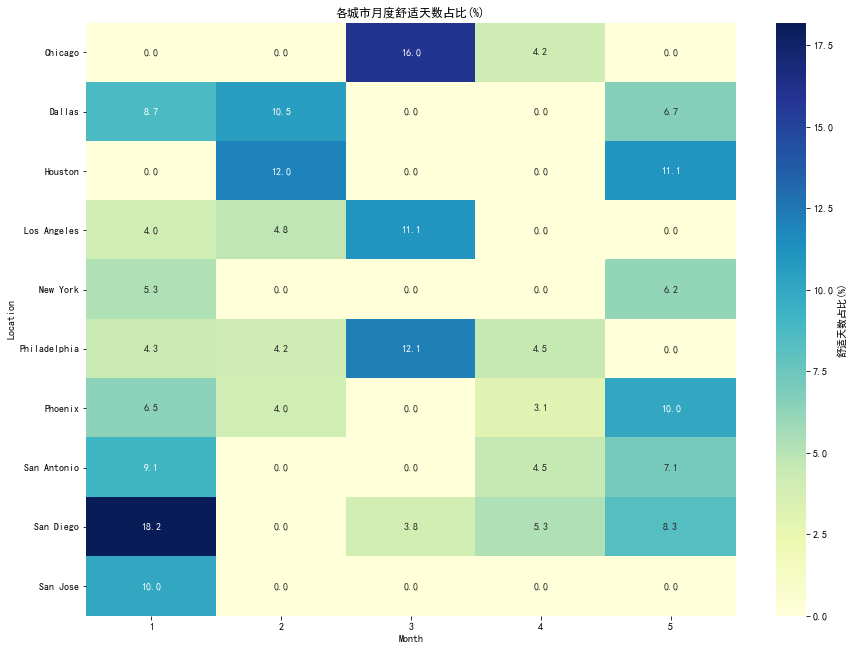

In [215]:
# 5.3 舒适度等级分布热力图
plt.figure(figsize=(32, 24)) 
plt.subplot(2, 2, 3)
heatmap_data = df.groupby(['Location', 'Month'])['Comfort_Level'].apply(
    lambda x: (x == '舒适').mean() * 100
).unstack()
sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='YlGnBu', cbar_kws={'label': '舒适天数占比(%)'})
plt.title('各城市月度舒适天数占比(%)')

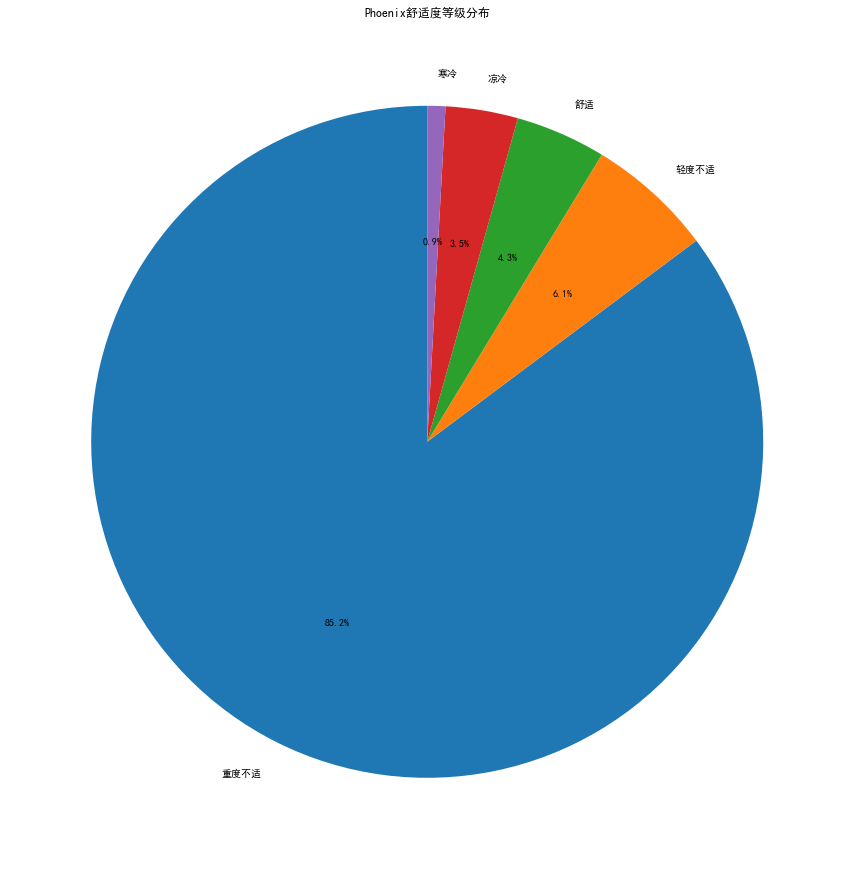

In [216]:
# 5.4 舒适度等级分布饼图（示例城市）
plt.figure(figsize=(32, 24)) 
plt.subplot(2, 2, 4)
comfort_dist = df[df['Location'] == sample_city]['Comfort_Level'].value_counts()
plt.pie(comfort_dist, labels=comfort_dist.index, autopct='%.1f%%', startangle=90)
plt.title(f'{sample_city}舒适度等级分布')

plt.tight_layout()
plt.show()

In [217]:
# 6. 输出统计结果
print("\n各城市THI统计：")
display(city_stats)

print("\n各城市月度舒适天数占比(%)：")
display(comfort_days)


各城市THI统计：


,THI_Mean,THI_Max,THI_Min,THI_Std
Location,,,,
Chicago,57.100481,100.82,20.92,19.088353
Dallas,58.620660,93.43,21.84,20.384103
Houston,59.407255,97.64,20.04,20.194383
Los Angeles,59.864426,100.84,22.44,19.488648
New York,58.125437,97.51,18.97,21.234719
Philadelphia,58.745214,96.95,20.62,20.532320
Phoenix,54.987913,92.07,11.55,21.539716
San Antonio,60.709487,96.72,20.46,20.034478
San Diego,55.939020,97.58,20.60,21.224656



各城市月度舒适天数占比(%)：


Month,1,2,3,4,5
Location,,,,,
Chicago,0.0,0.0,16.0,4.2,0.0
Dallas,8.7,10.5,0.0,0.0,6.7
Houston,0.0,12.0,0.0,0.0,11.1
Los Angeles,4.0,4.8,11.1,0.0,0.0
New York,5.3,0.0,0.0,0.0,6.2
Philadelphia,4.3,4.2,12.1,4.5,0.0
Phoenix,6.5,4.0,0.0,3.1,10.0
San Antonio,9.1,0.0,0.0,4.5,7.1
San Diego,18.2,0.0,3.8,5.3,8.3


In [224]:
# 准备聚类特征数据
cluster_features = df.groupby('Location').agg({
    'THI': ['mean', 'std', 'max', 'min'],  # THI统计特征
    'Temperature_C': 'mean',              # 平均温度
    'Humidity_pct': 'mean',               # 平均湿度
    'Wind_Speed_kmh': 'mean',             # 平均风速
    'Precipitation_mm': 'sum'             # 总降水量
}).reset_index()

# 扁平化多级列名
cluster_features.columns = ['_'.join(col).strip() if col[1] else col[0] 
                           for col in cluster_features.columns.values]

# 特征重命名简化
cluster_features = cluster_features.rename(columns={
    'THI_mean': 'THI_Mean',
    'THI_std': 'THI_Std',
    'THI_max': 'THI_Max',
    'THI_min': 'THI_Min',
    'Temperature_C_mean': 'Temp_Mean',
    'Humidity_pct_mean': 'Humidity_Mean',
    'Wind_Speed_kmh_mean': 'Wind_Mean',
    'Precipitation_mm_sum': 'Precip_Total'
})

# 标准化特征数据
scaler = StandardScaler()
features_to_scale = cluster_features.columns[1:]  # 排除Location列
scaled_features = scaler.fit_transform(cluster_features[features_to_scale])

In [225]:
# 确定最佳K值（肘部法则和轮廓系数）
inertia = []
silhouette_scores = []
k_range = range(2, 8)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)
    
    if k > 1:  # 轮廓系数需要至少2个聚类
        silhouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))

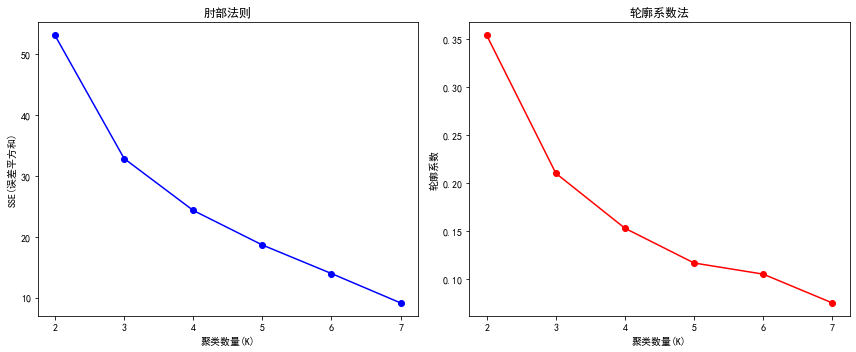

In [226]:
# 绘制肘部法则图
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('聚类数量(K)')
plt.ylabel('SSE(误差平方和)')
plt.title('肘部法则')

# 绘制轮廓系数图
plt.subplot(1, 2, 2)
plt.plot(range(2, 8), silhouette_scores, 'ro-')
plt.xlabel('聚类数量(K)')
plt.ylabel('轮廓系数')
plt.title('轮廓系数法')
plt.tight_layout()
plt.show()

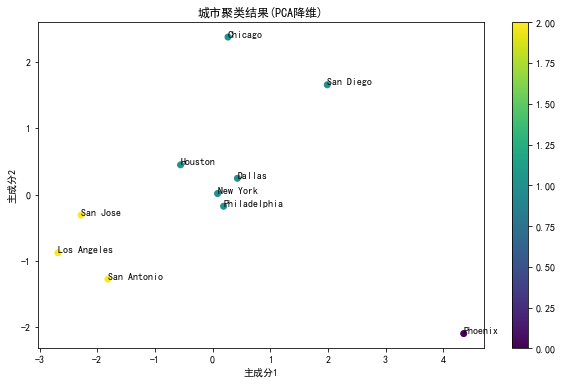


各聚类特征均值:


,THI_Mean,THI_Std,THI_Max,THI_Min,Temp_Mean,Humidity_Mean,Wind_Mean,Precip_Total
Cluster,,,,,,,,
0,54.987913,21.539716,92.070000,11.550000,12.375211,61.260551,14.817691,661.519612
1,57.989678,20.443089,97.321667,20.498333,14.510494,60.172793,14.949859,548.357316
2,60.422659,19.508899,98.926667,20.556667,16.191249,59.199676,14.317930,614.621304


In [227]:
# 根据图形选择最佳K值（这里假设K=3）
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans.fit(scaled_features)

# 将聚类结果添加到原始数据
cluster_features['Cluster'] = kmeans.labels_

# PCA降维可视化
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], c=cluster_features['Cluster'], cmap='viridis')
plt.colorbar(scatter)
for i, city in enumerate(cluster_features['Location']):
    plt.annotate(city, (pca_features[i, 0], pca_features[i, 1]))
plt.title('城市聚类结果(PCA降维)')
plt.xlabel('主成分1')
plt.ylabel('主成分2')
plt.show()

# 分析聚类特征
cluster_means = cluster_features.groupby('Cluster').mean()
print("\n各聚类特征均值:")
display(cluster_means)

In [228]:
# 定义聚类特征描述和推荐活动
cluster_descriptions = {
    0: {
        'name': '温暖湿润型',
        'description': 'THI较高，温度适中，湿度较大，降水较多',
        'activities': ['参观城市景点，博物馆、历史遗迹、美食探店', '可漫步沙滩、进行水上运动']
    },
    1: {
        'name': '凉爽干燥型',
        'description': 'THI较低，温度凉爽，湿度较低，风速较大',
        'activities': ['徒步、骑行、露营', '温泉体验、特色节庆', '赏花、野餐、摄影']
    },
    2: {
        'name': '寒冷干燥型',
        'description': 'THI低，温度低，湿度低，风速大',
        'activities': ['滑雪场滑雪', '温泉体验', '室内活动如博物馆参观']
    }
}

# 为每个城市分配推荐活动
city_recommendations = []
for _, row in cluster_features.iterrows():
    cluster_info = cluster_descriptions[row['Cluster']]
    city_recommendations.append({
        '城市': row['Location'],
        '聚类类型': cluster_info['name'],
        '特征描述': cluster_info['description'],
        '推荐旅游项目': ', '.join(cluster_info['activities'])
    })

recommendations_df = pd.DataFrame(city_recommendations)
print("\n各城市春季旅游推荐:")
display(recommendations_df)

# 保存结果
recommendations_df.to_csv('city_travel_recommendations.csv', index=False, encoding='utf-8-sig')


各城市春季旅游推荐:


,城市,聚类类型,特征描述,推荐旅游项目
0,Chicago,凉爽干燥型,THI较低，温度凉爽，湿度较低，风速较大,"徒步、骑行、露营, 温泉体验、特色节庆, 赏花、野餐、摄影"
1,Dallas,凉爽干燥型,THI较低，温度凉爽，湿度较低，风速较大,"徒步、骑行、露营, 温泉体验、特色节庆, 赏花、野餐、摄影"
2,Houston,凉爽干燥型,THI较低，温度凉爽，湿度较低，风速较大,"徒步、骑行、露营, 温泉体验、特色节庆, 赏花、野餐、摄影"
3,Los Angeles,寒冷干燥型,THI低，温度低，湿度低，风速大,"滑雪场滑雪, 温泉体验, 室内活动如博物馆参观"
4,New York,凉爽干燥型,THI较低，温度凉爽，湿度较低，风速较大,"徒步、骑行、露营, 温泉体验、特色节庆, 赏花、野餐、摄影"
5,Philadelphia,凉爽干燥型,THI较低，温度凉爽，湿度较低，风速较大,"徒步、骑行、露营, 温泉体验、特色节庆, 赏花、野餐、摄影"
6,Phoenix,温暖湿润型,THI较高，温度适中，湿度较大，降水较多,"参观城市景点，博物馆、历史遗迹、美食探店, 可漫步沙滩、进行水上运动"
7,San Antonio,寒冷干燥型,THI低，温度低，湿度低，风速大,"滑雪场滑雪, 温泉体验, 室内活动如博物馆参观"
8,San Diego,凉爽干燥型,THI较低，温度凉爽，湿度较低，风速较大,"徒步、骑行、露营, 温泉体验、特色节庆, 赏花、野餐、摄影"
9,San Jose,寒冷干燥型,THI低，温度低，湿度低，风速大,"滑雪场滑雪, 温泉体验, 室内活动如博物馆参观"


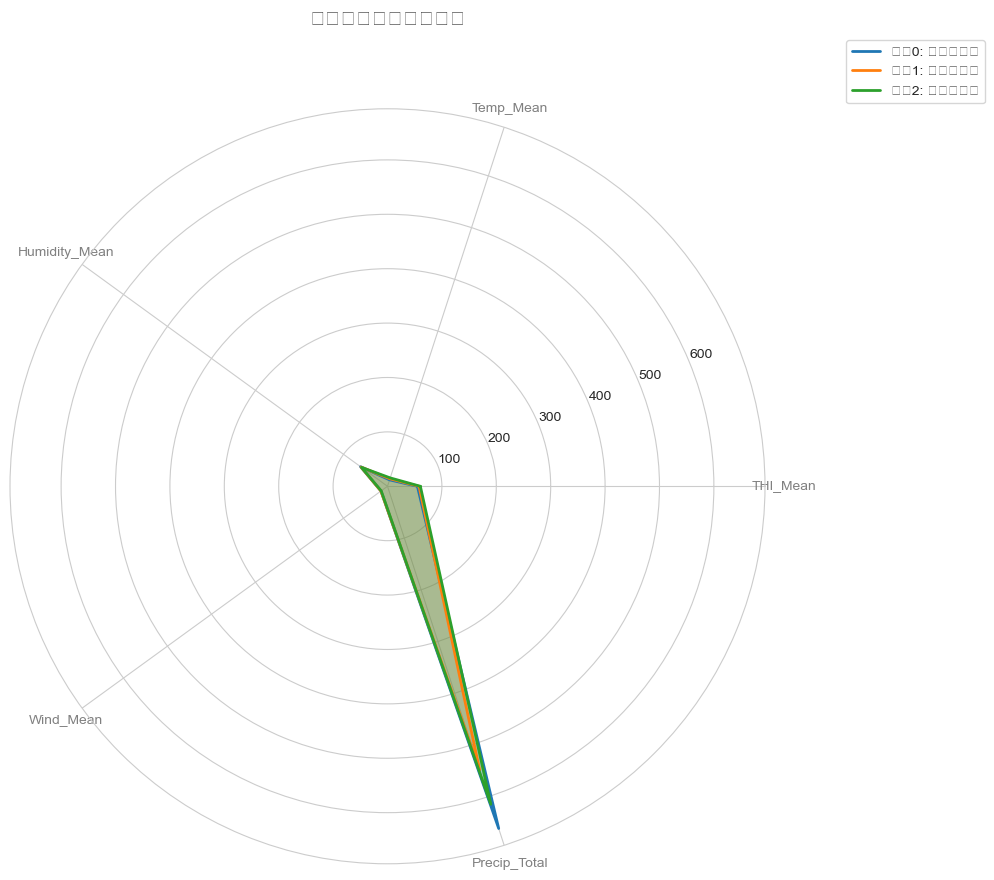

In [233]:
# 导入必要的库
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# 设置中文字体和样式
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

## 1. 聚类特征雷达图
def plot_cluster_radar(cluster_means, features):
    # 准备数据
    categories = features
    N = len(categories)
    
    # 计算角度
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    
    # 创建雷达图
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, polar=True)
    
    # 设置x轴标签
    plt.xticks(angles[:-1], categories, color='grey', size=10)
    
    # 绘制每个聚类的雷达图
    for cluster in cluster_means.index:
        values = cluster_means.loc[cluster].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', 
                label=f'聚类{cluster}: {cluster_descriptions[cluster]["name"]}')
        ax.fill(angles, values, alpha=0.25)
    
    # 添加标题和图例
    plt.title('各聚类特征对比雷达图', size=15, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

# 选择要展示的特征
selected_features = ['THI_Mean', 'Temp_Mean', 'Humidity_Mean', 'Wind_Mean', 'Precip_Total']
plot_cluster_radar(cluster_means[selected_features], selected_features)



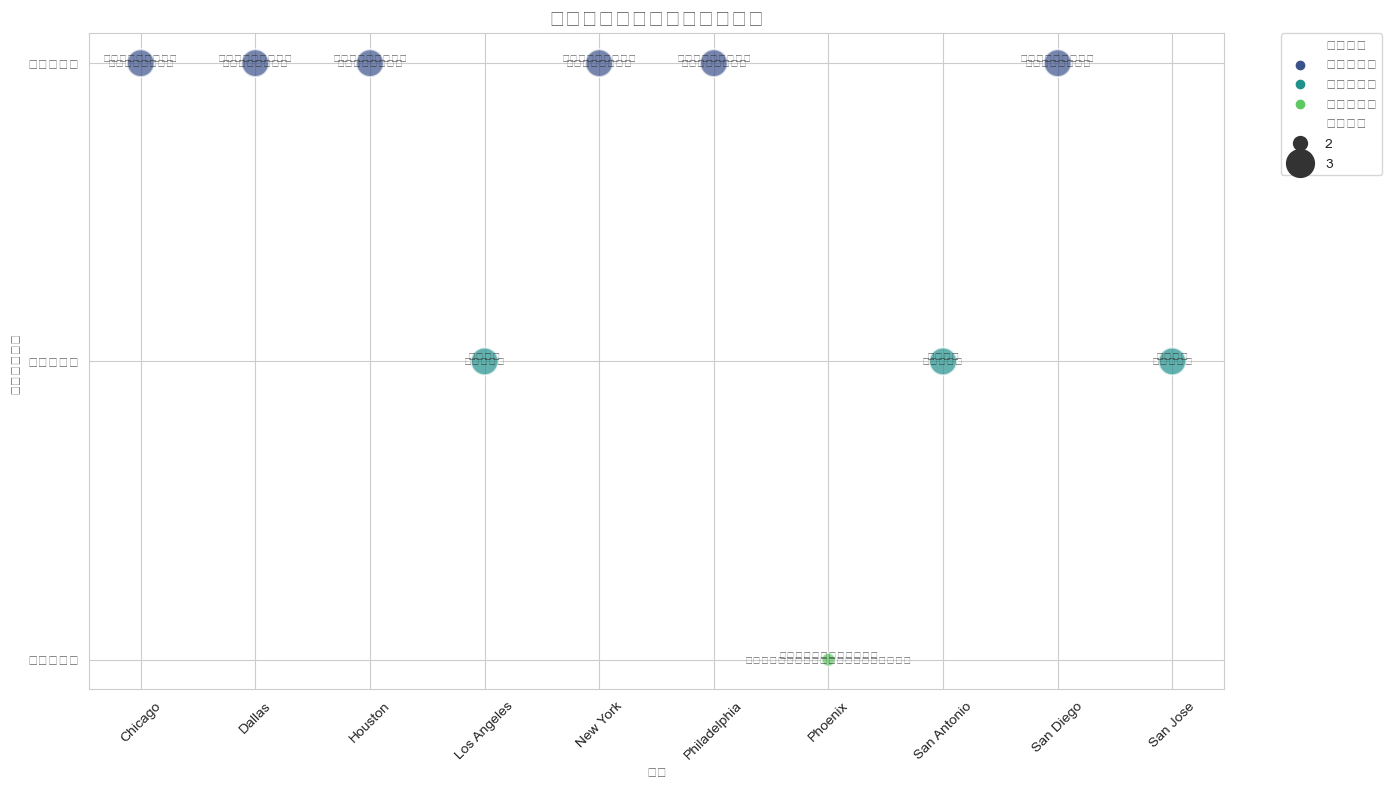

In [237]:
## 3. 旅游推荐气泡图
plt.figure(figsize=(14, 8))

# 准备数据
recommendations_df['活动数量'] = recommendations_df['推荐旅游项目'].str.split(',').apply(len)
recommendations_df['聚类类型'] = recommendations_df['聚类类型'].astype('category')

# 创建气泡图
scatter = sns.scatterplot(x='城市', y='聚类类型', size='活动数量',
                          hue='聚类类型', data=recommendations_df,
                          sizes=(100, 400), alpha=0.7, palette='viridis')

# 调整图例位置和样式
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('各城市春季旅游推荐项目分布', fontsize=16)
plt.xticks(rotation=45)
plt.ylabel('气候聚类类型')
plt.xlabel('城市')

# 添加推荐项目标签
for i, row in recommendations_df.iterrows():
    activities = row['推荐旅游项目'].split(', ')
    for j, activity in enumerate(activities[:2]):  # 只显示前两个活动避免拥挤
        plt.text(i, row['聚类类型'], activity, 
                 fontsize=8, ha='center', va='center' if j==0 else 'bottom')

plt.tight_layout()
plt.show()



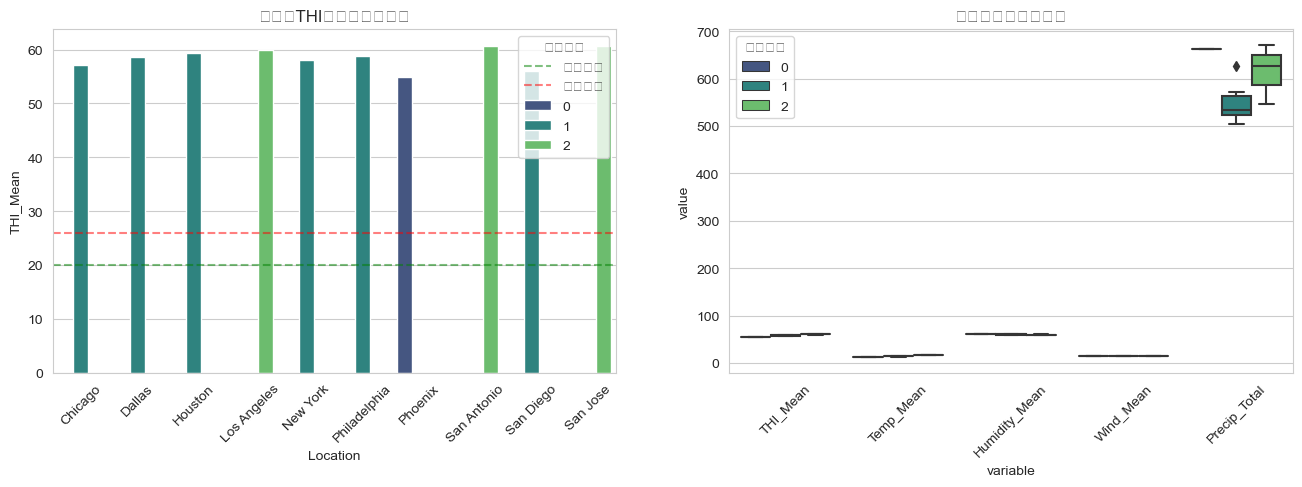

In [235]:
## 5. 各城市舒适度与推荐活动组合图
plt.figure(figsize=(16, 10))
gs = GridSpec(2, 2, figure=plt.gcf())

# 子图1: 各城市THI均值与聚类分布
ax1 = plt.subplot(gs[0, 0])
sns.barplot(x='Location', y='THI_Mean', hue='Cluster', 
            data=cluster_features, palette='viridis', ax=ax1)
ax1.axhline(y=20, color='green', linestyle='--', alpha=0.5, label='舒适下限')
ax1.axhline(y=26, color='red', linestyle='--', alpha=0.5, label='舒适上限')
ax1.set_title('各城市THI均值与聚类分布')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax1.legend(title='聚类类型')

# 子图2: 聚类特征箱线图
ax2 = plt.subplot(gs[0, 1])
melted_features = cluster_features.melt(id_vars=['Location', 'Cluster'], 
                                      value_vars=selected_features)
sns.boxplot(x='variable', y='value', hue='Cluster', 
            data=melted_features, palette='viridis', ax=ax2)
ax2.set_title('各聚类特征分布比较')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
ax2.legend(title='聚类类型')


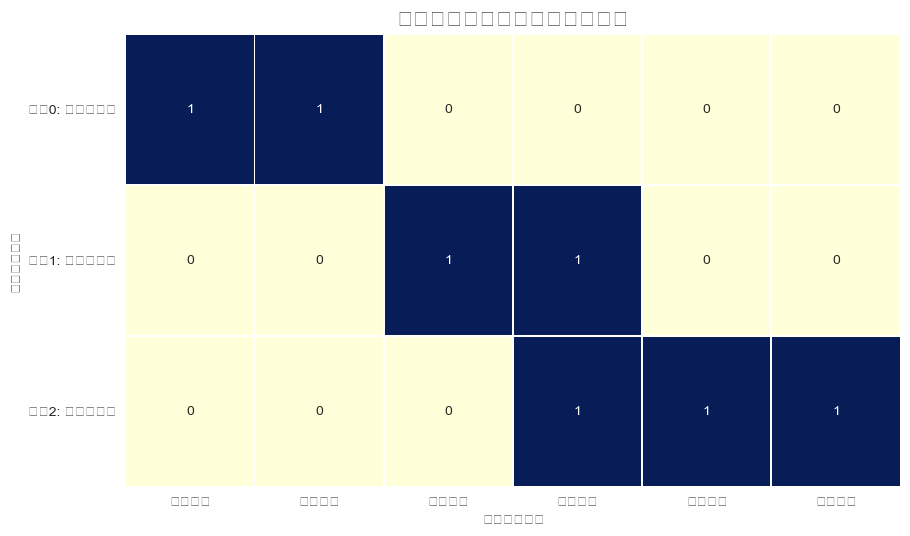

In [239]:
## 4. 聚类特征与活动关联热力图
# 准备数据
activity_matrix = pd.DataFrame(0, index=cluster_descriptions.keys(), 
                              columns=['城市观光', '水上活动', '户外运动', 
                                      '温泉体验', '滑雪活动', '室内活动'])

# 填充活动矩阵
for cluster, desc in cluster_descriptions.items():
    activities = desc['activities']
    if '参观城市景点' in ''.join(activities):
        activity_matrix.loc[cluster, '城市观光'] = 1
    if '漫步沙滩' in ''.join(activities):
        activity_matrix.loc[cluster, '水上活动'] = 1
    if '徒步、骑行' in ''.join(activities):
        activity_matrix.loc[cluster, '户外运动'] = 1
    if '温泉体验' in ''.join(activities):
        activity_matrix.loc[cluster, '温泉体验'] = 1
    if '滑雪场滑雪' in ''.join(activities):
        activity_matrix.loc[cluster, '滑雪活动'] = 1
    if '室内活动' in ''.join(activities):
        activity_matrix.loc[cluster, '室内活动'] = 1

# 重命名索引
activity_matrix.index = [f'聚类{cluster}: {desc["name"]}' 
                        for cluster, desc in cluster_descriptions.items()]

# 绘制热力图
plt.figure(figsize=(10, 6))
sns.heatmap(activity_matrix, annot=True, cmap="YlGnBu", 
            cbar=False, fmt='d', linewidths=.5)
plt.title('气候类型与推荐活动关联热力图', fontsize=16)
plt.ylabel('气候聚类类型')
plt.xlabel('推荐活动类别')
plt.yticks(rotation=0)
plt.show()